# 3 QPSK QAM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks"

## Pythonのバージョン確認と，必要なライブラリをインポートする．

In [ ]:
!python3 --version

import random

Python 3.7.14


In [ ]:
import matplotlib as makeMSL
import matplotlib.pyplot as plt
import numpy as np
import math

以下は$\mbox{erfc}$関数を読み込むためのライブラリ

In [ ]:
from scipy import special
from scipy.linalg import sqrtm

## 通信モデルに基づいたシミュレーション用のモジュール

*  情報源
*  情報源符号器
*  通信路符号器
*  通信路
*  白色ガウス雑音
*  通信路複復号器
*  情報源復号器

### 情報源
numpy.randomでも代用可

In [ ]:
'''
情報源クラス
'''
class InformationSource:
  def __init__(self,
                 N = 9,   #次数
                 a = 4, b = 9 #帰還タップ
                 ):
    self.N = N
    self.a = a
    self.b = b

  
  '''
  乱数(M系列)を発生させる
  @param informationSize int             発生させる乱数の個数
  @return information     numpy.ndarray 乱数
  '''
  def outputInformation(self, informationSize):
    information = np.empty(informationSize, dtype = int)

    for i in range(informationSize):
      if i < self.N :
        information[i] = random.randrange(2)
      else :
        information[i] = information[i - self.a] ^ information[i - self.b]

    return information

### 情報源符号器

In [ ]:
'''
情報源符号器
'''
class Encoder:
  '''
  @param M int 符号のビット数
  '''
  def __init__(self,
               M #符号のビット数
               ) :
    self.M = M

    #２進数のマスク
    self.mask = np.array([1 << bit for bit in range(M)])
  
  '''
  0/1乱数をM[bit]の符号にする
  @param information numpy.ndarray 0/1の乱数(情報)
  @return data        numpy.ndarray 符号
  '''
  def encode(self,
             information):
    information2 = np.concatenate([information, information])

    data = np.array([
        self.mask @ information2[i: i + self.M] 
        for i in range(information.size)
    ])
    data = np.reshape(data, (1, data.size))

    return data

    return np.array([
        np.array([self.mask @ information2[i: i + self.M] ])
        for i in range(information.size)
    ])
    
    '''
    return np.array([
        self.mask @ information2[i: i + self.M]
        for i in range(information.size)
    ])
    '''

### 通信路符号器

Mは単位が[bit]とする
**MPSKのとき**$$\mathbb{Z} \mapsto \mathbb{C}:x\mapsto \sqrt{P_s} \cdot  \exp\Big(j\frac{2\pi}{2^M}x\Big)$$  <br>

**MQAMのとき**<br>データ$x$を上位ビット$x^U$，下位ビット$x^L$に分けて
$$
f:\times2d - (2^{M/2} - 1)d
$$
を作用させてそれぞれ複素信号$s$の実部$s^I$と虚部$s^Q$とする． <br>
ただし$2d$は信号点間隔であり，電力$\mathbb{E}\big[|s|^2\big]$を$P_S$に固定するとき
$$
P_S = 
\frac{1}{2^M} \cdot
\sum_{x \in \{0, 1, \cdots 2^M - 1\} }
  \Bigg\| f(x^U) + jf(x^L) \Bigg\|^2
$$

より$d$は以下のように確定する.

$$
d = \sqrt{\frac{3}{2} \frac{P_S}{2^M - 1 } }
$$

In [ ]:
'''
通信路符号器
'''
class Modulator:
  '''
  constructor
  @param M              int   多値数[bit] 単位がビットであることに注意
  @param mode          str   変調方式 ex) mode = "PSK", mode = "QAM"
  @param isGrayCode    bool  グレイコードにするか否か
  @param powerOfSignal float １シンボルあたりの送信電力 (１ビットあたりの送信電力ではない！)
  '''
  def __init__(self,
               M,
               mode,
               isGrayCode = True,
               powerOfSignal  = 1.0
               ):
    
    self.M = M
    self.mode = mode
    self.isGrayCode = isGrayCode
    self.powerOfSignal = powerOfSignal

    if mode == "QAM":
      self.d = math.sqrt(
          1.5 * self.powerOfSignal / ( (1 << self.M) - 1 )
      )
    
    elif mode == "PSK":
      self.A  = math.sqrt( self.powerOfSignal )

  '''
  変調
  @param data     np.ndarray データ
  @return symbol  np.ndarray シンボル
  '''
  def modulate(self,data):
    if self.mode == "PSK":
      if self.isGrayCode == True:
        data = self.grayEncode(data)
      return self.A * np.exp(1j * 2.0 * np.pi/ (1 << self.M) * data)
    
    if self.mode == "QAM":
      x_U = self.sliceUpperBit(data)
      if self.isGrayCode == True:
        x_U = self.grayEncode(x_U)

      x_L = self.sliceLowerBit(data)
      if self.isGrayCode  == True:
        x_L = self.grayEncode(x_L)

      s_I = self.f(x_U)
      s_Q = self.f(x_L)
      return s_I + 1j * s_Q
  
  '''
  上位ビット取得
  @param x    np.ndarray {0, 1, ..., 2^M - 1} データ
  @return x_U np.ndarray 上位ビット
  '''
  def sliceUpperBit(self, x) :
    return (
        x >> (self.M//2)
    )
  
  '''
  下位ビット取得
  @param x    np.ndarray {0, 1, ..., 2^M - 1} データ
  @return x_D np.ndarray 下位ビット
  '''
  def sliceLowerBit(self, x) :
    return x & (
        ( 1 << (self.M//2) ) - 1
    )
  
  '''
  M/2ビットを等間隔に配置
  @param x_           np.ndarray  M/2ビットのデータ
  @return symbolPart   np.ndarray  信号点のI/Q座標
  '''
  def f(self, x_):
    return self.d * (
          x_ * 2 - (
              (1 << (self.M//2) ) - 1
            )
        )
  
  '''
  グレイコードにする
  @param n            array_like integer
  @return              array_like gray coded object
  '''
  def grayEncode(self, n):
    return n ^ n >> 1
  
  '''
  グレイコードから直す
  @param n           array_like gray coded object
  @return             array_like gray decoded object
  '''
  def grayDecode(self, n):
    i = isinstance(n, int)
    n = np.array([n]) if i else n.copy()
    m = n >> 1
    while not (m == 0).all():
        n ^= m
        m >>= 1
    return n[0] if i else n
  
  '''
  信号点配置の表示と電力を計算する
  '''
  def debug(self):
    dataSet = np.arange(1 << self.M)
    dataset = self.grayEncode(dataSet)
    symbolSet = self.modulate(dataSet)

    plt.scatter( symbolSet.real, symbolSet.imag, label = "{}{}".format(1 << self.M, self.mode))
    for n in range(1 << self.M):
      data = dataSet[n]
      symbol = symbolSet[n]
      plt.annotate("${}$".format( format(data, 'b') ), xy = (symbol.real, symbol.imag))

    plt.xlabel("I")
    plt.ylabel("Q")


    plt.legend()
    plt.savefig("{}{}.png".format(
        1 << self.M,
        self.mode  
      )
    )

    plt.show()

    print("calculated power of signal: {}".format(
        math.sqrt(
          np.mean( np.abs(symbolSet) ** 2 )
        )
      )
    )

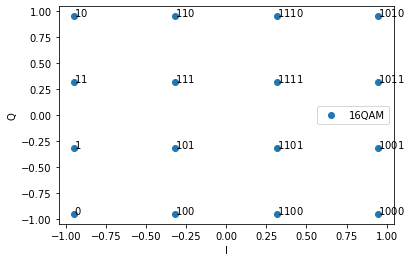

calculated power of signal: 1.0


In [ ]:
modulatorTest = Modulator(
    M = 4,
    mode = "QAM",
    isGrayCode = True
)

modulatorTest.debug()

### 通信路

In [ ]:
'''
通信路
'''
class Channel:
  '''
  @param channelMatrix np.ndarray チャネル行列H
  '''
  def __init__(self, channelMatrix):
    self.channelMatrix = channelMatrix
  
  '''
  シンボルsを通信路Hに通して出力( y = Hu 出力)
  @param symbol np.ndarray 入力シンボル
  @reutrn         np.ndarray 出力シンボル
  '''
  def transport(self, symbol):
    return self.channelMatrix @ symbol

In [ ]:
'''
クロネッカーモデル通信路
'''
class KroneckerChannel(Channel):
  '''
  @paran Nt   送信アンテナ数
  @paran Nr   受信アンテナ数
  @param rho 相関係数
  @param
  '''
  def __init__(self, Nt, Nr, rho):
    self.Nt = Nt
    self.Nr = Nr
    self.rho = rho
    
    self.Rt = self.Nt * self.exponentialCorrelationMatrix(self.Nt, self.rho)
    self.G = self.gaussianMatrix(self.Nr, self.Nt)
    self.Rr = self.Nr * self.exponentialCorrelationMatrix(self.Nr, self.rho)
    self.kappa = np.trace(self.Rt)


    self.H = self.calcKroneckerChannel(self.Rt, self.G, self.Rr, self.kappa)
  
  def exponentialCorrelationMatrix(self, N, rho):
    mat = np.array([
        [ i - j for j in range(N) ]
        for i in range(N)
    ])
    mat = np.abs(mat)
    mat = np.power(rho, mat)
    return mat
  
  def gaussianMatrix(self, rowNum, colNum):
    mat = np.array([
        [
            random.gauss(mu = 0, sigma = np.sqrt(0.5) ) + 1j * random.gauss(mu = 0, sigma = np.sqrt(0.5) ) 
            for col in range(colNum)
        ]
        for row in range(rowNum)
    ])
    return mat
  
  '''
  H = Rr^{1/2} G ( Rr^{1/2} )^H / \sqrt{\kappa}
  '''
  def calcKroneckerChannel(self, Rt, G, Rr, kappa):
    return sqrtm(Rr) @ G @ (sqrtm(Rt)).conj().T / np.sqrt(kappa)

  def debug(self):
    print("start debug")
    #print( self.exponentialCorrelationMatrix(3, 0) )
    
    Rt = np.zeros( (self.Nt, self.Nt) )
    
    N = 1000
    for n in range(N):
      G = self.gaussianMatrix(self.Nr, self.Nt)
      H = self.calcKroneckerChannel(self.Rt, G, self.Rr, self.kappa)

      Rt_ = H.conj().T @ H

      Rt = Rt + Rt_
    
    Rt /= N
    print("Rt/Nr{}".format( Rt/self.Nr ))


    print("end debug")

### 白色ガウス雑音加算器
複素ガウス分布に従う雑音$\boldsymbol{n}$をBox-Muller法で発生させる．
$$
\boldsymbol{n} \sim \mathcal{CN}( 0, \sigma^2  )
$$
実部と虚部は$\mathcal{N}(0, \sigma^2/2)$に従うことに注意

In [ ]:
class AwgnAdder:
  '''
  constructor
  '''
  def __init__(self):
    return
  
  '''
  シンボルにガウスノイズn ~ CN(0, σ^2)をのせて返す
  @param symbol  np.ndarray       シンボル
  @param variance float            分散
  @return symbolNoizes np.ndarray ノイズが加算されたシンボル
  '''
  def addAwgn(self, symbol, variance):
    noizeVector = np.array([
          self.generateGaussian(variance) for _ in range(symbol.size)
        ])
    noizeMatrix = noizeVector.reshape( symbol.shape )
    return symbol + noizeMatrix

  ''''
  複素標準ガウス雑音n ~ CN(0, σ^2)生成
  @param variance float     分散σ^2
  @return gaussian complex 複素標準ガウス雑音n ~ CN(0, σ^2)
  '''
  def generateGaussian(self, variance):
    #確率変数x_1, x_2 ~ U(0, 1)
    x_1 = random.uniform(0.0, 1.0)
    x_2 = random.uniform(0.0, 1.0)

    #確率変数x_1, x_2を変換して標準正規分布に従う確率変数y_1, y_2とする
    y_1 = np.sqrt(-2.0 * np.log(x_1)) * np.cos(2.0 * np.pi * x_2)
    y_2 = np.sqrt(-2.0 * np.log(x_1)) * np.sin(2.0 * np.pi * x_2)

    return np.sqrt( variance / 2.0) * (y_1 + 1j * y_2)

### 通信路複復号器

***MPSK M$[\rm{bit}]$*** のとき <br>
受け取った信号$y$に対して
$$
\hat{x} = \rm{round} \Bigg( 
  \frac{
  \rm{arg}(y)
}{
  2 \pi / 2^M
} \Bigg)
$$
と復調する．<br>

***MQAM M$[\rm{bit}]$***のとき <br>
受け取った信号$y = y^I + j y^Q$に対して
$$
\hat{x}^{(\cdot)}  = \rm{round}\Bigg(
  \frac{1}{2}
  \bigg\{
    \frac{y^{(\cdot)} }{d} + 2^{M/2} - 1
  \bigg\}
  \Bigg)
$$
として上位ビット$\hat{x}^U$および下位ビット$\hat{x}^D$と復調する. <br>
ただし$\hat{x}^{(\cdot)} < 0$のとき$\hat{x}^{(\cdot)} = 0$, $\hat{x}^{(\cdot)} \geq 2^{M/2}$のとき$\hat{x}^{(\cdot)} = 2^{M/2} - 1$とする．<br>

また，計算量はあるが確実な方法として最小ノルムを指定するシンボルを推定地にする復調法も実装した．すなわち
$$
\hat{x} = \rm{arg min}_{x \in \{0, 1, \cdots, 2^M-1\} } \Big\| \rm{modulate} (x) - y \Big\|
$$

In [ ]:
class Demodulator(Modulator):
  '''
  constructor
  @param M              int   多値数[bit] 単位がビットであることに注意
  @param mode          str   変調方式 ex) mode = "PSK", mode = "QAM"
  @param argmin         bool argminで復調するか否か
  @param powerOfSignal float １シンボルあたりの送信電力 (１ビットあたりの送信電力ではない！)
  '''
  def __init__(self,
               M,
               mode,
               isGrayCode = True,
               powerOfSignal  = 1.0,
               argmin = False
               ):
    super().__init__(M, mode, isGrayCode, powerOfSignal)
    self.argmin = argmin
    self.dataOrigin = np.arange(1 << self.M)
    if self.isGrayCode == True:
      self.dataOrigin =  self.grayEncode( self.dataOrigin )
    self.symbolOrigin = self.modulate(self.dataOrigin)
    
    

  '''
  復調
  @param symbolReceived         np.ndarray 受け取ったシンボル
  @return dataDemodulated       np.ndarray 復調されたデータ
  '''
  def demodulate(self, symbolReceived):
    if self.argmin == True:
      dataDemodulated =  np.array([
          np.argmin(
              abs(self.symbolOrigin - symbolReceived_) 
          )
          for symbolReceived_ in symbolReceived
      ])

      if self.isGrayCode == True:
        dataDemodulated = self.grayDecode( dataDemodulated )

    elif self.mode == "PSK":
      dataDemodulated = np.angle( symbolReceived )
      dataDemodulated = dataDemodulated / (
          2.0 * np.pi / ( 1 << self.M )
      )
      dataDemodulated = dataDemodulated.round()
      dataDemodulated = np.array(dataDemodulated.round(), dtype = 'int')
      dataDemodulated = np.where(dataDemodulated < 0,
                                   dataDemodulated + (1 << self.M),
                                   dataDemodulated)
      if self.isGrayCode == True:
        dataDemodulated = self.grayDecode( dataDemodulated )
    
    elif self.mode == "QAM":
      x_U = symbolReceived.real / self.d + (1 << self.M//2) - 1
      x_U /= 2.0
      x_U = x_U.round()
      x_U = np.array(x_U, dtype = 'int')
      x_U = np.where(x_U < 0, 0, x_U)
      x_U = np.where(x_U > ( (1 << self.M//2) - 1), (1 << self.M//2) - 1, x_U)

      x_L = symbolReceived.imag / self.d + (1 << self.M//2) - 1
      x_L /= 2.0
      x_L = x_L.round()
      x_L = np.array(x_L, dtype = 'int')
      x_L = np.where(x_L < 0, 0, x_L)
      x_L = np.where(x_L > ( (1 << self.M//2) - 1), (1 << self.M//2) - 1, x_L)

      if self.isGrayCode == True:
        x_U = self.grayDecode(x_U)
        x_L = self.grayDecode(x_L)
      
      dataDemodulated = (x_U << self.M//2) + x_L
    
    return dataDemodulated
  
  '''
  信号点配置の表示と電力を計算する
  '''
  def debug(self):
    dataSet = np.arange(1 << self.M)
    symbolSet = self.modulate(dataSet)

    dataDemodulated = self.demodulate( symbolSet )
    print("data origin: {}".format(dataSet))
    print("data demodulated {}: ".format(dataDemodulated) )

## その他のモジュール

### $\rm{SNR}$もしくは$\frac{E_b}{N_0}$から雑音$\boldsymbol{n} $の分散$\sigma^2$を計算する関数

**SN比から雑音の分散を計算**<br>繰り返し記述しておくが，雑音$ \boldsymbol{n}$の実部，虚部はそれぞれ$\mathcal{N} (0, \sigma^2/2)$に従う.
$$
\rm{SNR} [\mbox{dB}]  = 10 \log_{10} \frac{P_S}{P_N} = 10 \log_{10} \frac{1}{  \sigma^2 }
$$

$$
\therefore
\rm{分散} \sigma^2 = 10^{- \rm{SNR}/10 }
$$

**$\frac{ E_b }{ N_0 }$から雑音の分散を計算**<br>


$$
\begin{cases}
P_S &= M[\rm{bit}] \times E_b \\
\frac{E_b}{N_0} &= 10 \log_{10} \Big( \frac{ E_b }{ \sigma^2 } \Big) 
\end{cases}
$$


$$
\therefore \mbox{分散} \sigma^2 = \frac{P_S}{ M[\rm{bit}] } 10^{
 - E_b/N_0 \big/ 10
}
$$

In [ ]:
'''
雑音分散を計算
@param rate          float     SNR or EbN0
@param rateMode    str      "SNR" or "EbN0"
@param M            int      多値数[bit]
@param P_S          float    信号電力
@return variance      float    雑音の分散
'''
def calcVariance(
    rate,
    rateMode,
    M,
    P_S = 1.0
):
  if rateMode == "SNR" :
    return np.power(10.0, - rate / 10.0 )
  
  elif rateMode == "EbN0":
    return P_S / M * np.power(10.0, - rate / 10.0)

### SER/BER計算機
送信したデータセットと，復調したデータセットの中身のうち正しく予測したものの割合

In [ ]:
'''
SER/BER計算機
@param M              int 多値数[bit]
@param errrorMode     str "SER" or "BER"
'''
class ErrorCalculator:
  def __init__(self, M, errorMode) :
    self.M = M
    self.errorMode = errorMode

  
  '''
  SER or BER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcError(self,
                dataOrigin,
                dataDemodulated):
    if self.errorMode == "SER":
      return self.calcSER(dataOrigin, dataDemodulated)
    
    elif self.errorMode == "BER":
      return self.calcBER(dataOrigin, dataDemodulated)

  '''
  SER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcSER(self, 
              dataOrigin,
              dataDemodulated):
    return np.count_nonzero(
        dataOrigin != dataDemodulated
    ) / dataOrigin.size

  '''
  BER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcBER(self,
              dataOrigin,
              dataDemodulated):
    dataDelta = dataOrigin ^ dataDemodulated
    dataDeltaBits = np.array([
        self.transformBitsFromInt(data)
        for data in dataDelta
        ])
    '''
    or
    dataDeltaBits = self.transformBitsFromInt(data)
    '''

    deltaCnt = np.sum( dataDeltaBits )

    return deltaCnt / dataDeltaBits.size

  '''
  整数を{0,1}^(桁数)に変換
  @param integer          int        変換する整数
  @return bits             np.ndarray 変換された0/1ビット配列
  '''
  def transformBitsFromInt(self, integer):
    return np.array([
        ( integer & (1 << m) ) >> m
        for m in range( self.M )
    ])


### SER, BERの理論式

$M$[bit]個のビット列からなるシンボル誤り率$P_{\rm{SER}}$は，ビット誤り率$P_{\rm{BER}}$と
$$
P_\rm{BER} = \frac{2^{M-1}}{2^M - 1} P_\rm{SER}
$$
という関係がある．<br>

**PSK**の理論式
$M = 1$(BPSK)のとき
$$
P_\rm{SER} = \frac{1}{2} \rm{erfc}( \sqrt{\gamma} )
$$

それ以外
$$
P_\rm{SER} \simeq \rm{erfc} \Bigg(\sqrt{\gamma} \sin \frac{\pi}{2^M}\Bigg)
$$

**QAM**の理論式

$$
P_\rm{SER} \simeq 2\Big(1 - \frac{1}{ 2^{M/2} } \Big) \rm{erfc}
\Bigg[ 
\sqrt{ \frac{3}{2(2^M - 1)} \cdot \gamma}
\Bigg]
$$
ただし$\gamma_p$は最大振幅を持つ信号の電力対雑音電力比

あるいは
$$
P_{BER} = P_{SER} if PSK \\
P_{BER} = \alpha \ \rm{erfc}\Big( \sqrt{
  \frac{\gamma}{\beta}
}  \Big)
$$

| | | |
| --- | --- | --- |
|  | $\alpha$ | $\beta$ |
| QPSK | 1/2 | 2 |
| 16QAM | 3/8 | 10 |
| 64QAM | 7/24 | 42 |
| 256QAM | 15/64 | 42 | 
| 1024QAM | 31/160 | 682 |


In [ ]:
'''
SNR or Eb/N0によるSER or BERの理論式
@param M            int     多値数[bit]
@param mode        str    "PSK" or "QAM"
@param gammaMode str    "EbN0" or "SNR"
@param gamma      float   SN比
@param errorMode   str    "SER" or "BER"

@return P_e       float 誤り率(P_SER or P_BER)
'''
def errorTheoreticalValue(
    M,
    mode,
    gammaMode,
    gamma,
    errorMode
) :
  if gammaMode == "EbN0":
    gamma *= M
  


  if mode == "PSK":
    P_SER = special.erfc(
        np.sqrt(gamma) * np.sin( np.pi / (1 << M) )
    )
    if M == 1:
      P_SER /= 2
  

  elif mode == "QAM":
    P_SER = 2.0 * (1.0 - 1.0/(1<< M//2) ) * special.erfc( np.sqrt(
          3.0 / (2.0 * ( (1 << M) - 1) ) * gamma
        )
      )



  if errorMode == "SER":
    return P_SER
 

  elif errorMode == "BER":
    if mode == "QAM":
      if M > 10:
        P_BER = P_SER / M
        #P_BER = (1 << (M  - 1)) / ( (1 << M) - 1) * P_SER
      else:  
        if M == 4: #16QAM
          alpha, beta = 3/8, 10
        elif M == 6: #64QAM
          alpha, beta = 7/24, 42
        elif M == 8: #256QAM
          alpha, beta = 15/64, 170
        elif M == 10: #1024QAM
          alpha, beta = 31/160, 682
        P_BER = alpha * special.erfc( np.sqrt( gamma / beta ) )
      
    else: #PSK
      P_BER = P_SER / M
      #P_BER = (1 << (M  - 1)) / ( (1 << M) - 1) * P_SER
 
    return P_BER

## Simulation of PSK

### BPSK

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 2(BPSK) |
|  試行回数  |  100万回  |
|  SNR(=EbN0)  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#変調方式
mode = "PSK"

#多値数
M = 1

#試行回数
informationSize = 1000000

#SNR
rateMode = "SNR"
SNR_MIN = 0
SNR_MAX = 30

#定義域(SNR)
N = (SNR_MAX - SNR_MIN) + 1
SNR = np.linspace(SNR_MIN, SNR_MAX, N)

#送信電力
powerOfSignal = 1.0

通信モデル等設定

In [ ]:
#informationSource = InformationSource()
#encoder = Encoder(M = M)
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M)

In [ ]:
#乱数データ
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])

#データを変調しておく
symbol = modulator.modulate(dataOrigin)

#### 実行結果
横軸 SNR:0∼10 [dB]，縦軸 BER(対数表示)のグラフを描く.

In [ ]:
BER_SNR_BPSK = np.zeros(shape = SNR.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = SNR[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcBER(dataOrigin, dataDemodulated)

  BER_SNR_BPSK[n] = ber

  print("SNR:{}  BER:{}".format(SNR[n], ber))

np.savetxt("BER_SNR_BPSK.csv",
           np.stack([
               SNR,
               BER_SNR_BPSK
           ])
        )

SNR:0.0  BER:0.078718
SNR:1.0  BER:0.056319
SNR:2.0  BER:0.037589
SNR:3.0  BER:0.02278
SNR:4.0  BER:0.012437
SNR:5.0  BER:0.006159
SNR:6.0  BER:0.002349
SNR:7.0  BER:0.000838
SNR:8.0  BER:0.000192
SNR:9.0  BER:3.3e-05
SNR:10.0  BER:7e-06
SNR:11.0  BER:0.0
SNR:12.0  BER:0.0
SNR:13.0  BER:0.0
SNR:14.0  BER:0.0
SNR:15.0  BER:0.0
SNR:16.0  BER:0.0
SNR:17.0  BER:0.0
SNR:18.0  BER:0.0
SNR:19.0  BER:0.0
SNR:20.0  BER:0.0
SNR:21.0  BER:0.0
SNR:22.0  BER:0.0
SNR:23.0  BER:0.0
SNR:24.0  BER:0.0
SNR:25.0  BER:0.0
SNR:26.0  BER:0.0
SNR:27.0  BER:0.0
SNR:28.0  BER:0.0
SNR:29.0  BER:0.0
SNR:30.0  BER:0.0


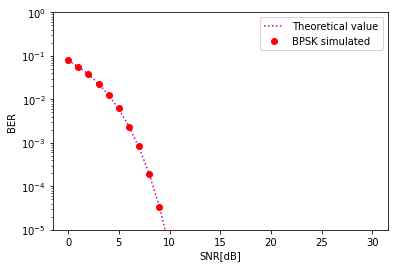

In [ ]:
plt.plot(
    SNR,
    0.5 * special.erfc(
        np.sqrt(
            np.power(10, SNR / 10.0 ) 
        )
    ),
    ':m',
    label = "Theoretical value"
)

plt.plot(
    np.loadtxt("BER_SNR_BPSK.csv")[0],
    np.loadtxt("BER_SNR_BPSK.csv")[1],
    'or',
    label = "BPSK simulated"
)

plt.yscale('log')

plt.xlabel("SNR[dB]")
plt.ylabel("BER")

plt.ylim(10 ** (-5), 1)

plt.legend()

plt.savefig("BER_SNR_BPSK.png")

plt.show()

### QPSK

#### SER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 4(QPSK) |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
iterationNum = 1000000

#Eb/N0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

通信モデル等設定

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M)

TypeError: ignored

In [ ]:
#乱数データ
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])

#データを変調しておく
symbol = modulator.modulate(dataOrigin)

In [ ]:
dataOrigin

array([[0, 3, 1, ..., 0, 0, 1]])

##### 実行結果
横軸 $E_b/N_0$[dB]，縦軸 SER(対数表示)のグラフを描く.

In [ ]:
SER_EbN0_QPSK = np.zeros(shape = SNR.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = SNR[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてSER計算
  ser = errorCalculator.calcSER(dataOrigin, dataDemodulated)

  SER_EbN0_QPSK[n] = ser
  print("EbN0 :{} SER:{}".format(EbN0[n], ser) )

EbN0 :0.0 SER:0.150999
EbN0 :1.0 SER:0.109952
EbN0 :2.0 SER:0.074074
EbN0 :3.0 SER:0.045463
EbN0 :4.0 SER:0.025075
EbN0 :5.0 SER:0.01182
EbN0 :6.0 SER:0.004859
EbN0 :7.0 SER:0.001506
EbN0 :8.0 SER:0.000394
EbN0 :9.0 SER:6.1e-05
EbN0 :10.0 SER:1.7e-05
EbN0 :11.0 SER:0.0
EbN0 :12.0 SER:0.0
EbN0 :13.0 SER:0.0
EbN0 :14.0 SER:0.0
EbN0 :15.0 SER:0.0
EbN0 :16.0 SER:0.0
EbN0 :17.0 SER:0.0
EbN0 :18.0 SER:0.0
EbN0 :19.0 SER:0.0
EbN0 :20.0 SER:0.0
EbN0 :21.0 SER:0.0
EbN0 :22.0 SER:0.0
EbN0 :23.0 SER:0.0
EbN0 :24.0 SER:0.0
EbN0 :25.0 SER:0.0
EbN0 :26.0 SER:0.0
EbN0 :27.0 SER:0.0
EbN0 :28.0 SER:0.0
EbN0 :29.0 SER:0.0
EbN0 :30.0 SER:0.0


In [ ]:
np.savetxt("SER_EbN0_QPSK.csv", np.stack([
    EbN0,
    SER_EbN0_QPSK
]))

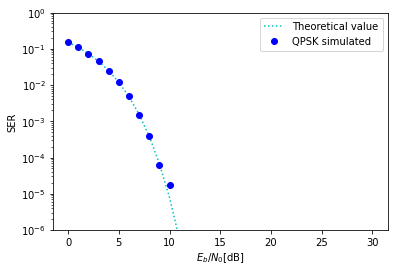

In [ ]:
plt.plot(
    SNR,
    special.erfc( np.sqrt( 1.0/2.0 * 2 * np.power(10, SNR/10.0) ) ) * (
        1.0 - 1.0/4.0 * special.erfc(
        np.sqrt( 1.0/2.0 * 2 * np.power(10, SNR / 10.0 ) )
      )
    )
    ,
    ':c',
    label = "Theoretical value"
)

plt.plot(
    np.loadtxt("SER_EbN0_QPSK.csv")[0],
    np.loadtxt("SER_EbN0_QPSK.csv")[1],
    'ob',
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("SER")

plt.ylim(10 ** (-6), 1)

plt.legend()

plt.savefig("SER_EbN0_QPSK.png")

plt.show()

####  BER - E_b/N_0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 4(QPSK) |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
informationSize = 1000000

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])
symbol = modulator.modulate(dataOrigin)

In [ ]:
BER_EbN0_QPSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  BER_EbN0_QPSK[n] = ber
  print("EbN0: {} BER: {}".format( EbN0[n], ber) )

np.savetxt(path + "/BER_EbN0_QPSK.csv", np.stack([
    EbN0,
    BER_EbN0_QPSK
]))

EbN0: 0.0 BER: 0.078756
EbN0: 1.0 BER: 0.056095
EbN0: 2.0 BER: 0.037605
EbN0: 3.0 BER: 0.0228855
EbN0: 4.0 BER: 0.0125165
EbN0: 5.0 BER: 0.0058905
EbN0: 6.0 BER: 0.0023745
EbN0: 7.0 BER: 0.0007415
EbN0: 8.0 BER: 0.0001855
EbN0: 9.0 BER: 3.1e-05
EbN0: 10.0 BER: 5e-06
EbN0: 11.0 BER: 0.0
EbN0: 12.0 BER: 0.0
EbN0: 13.0 BER: 0.0
EbN0: 14.0 BER: 0.0
EbN0: 15.0 BER: 0.0
EbN0: 16.0 BER: 0.0
EbN0: 17.0 BER: 0.0
EbN0: 18.0 BER: 0.0
EbN0: 19.0 BER: 0.0
EbN0: 20.0 BER: 0.0
EbN0: 21.0 BER: 0.0
EbN0: 22.0 BER: 0.0
EbN0: 23.0 BER: 0.0
EbN0: 24.0 BER: 0.0
EbN0: 25.0 BER: 0.0
EbN0: 26.0 BER: 0.0
EbN0: 27.0 BER: 0.0
EbN0: 28.0 BER: 0.0
EbN0: 29.0 BER: 0.0
EbN0: 30.0 BER: 0.0


##### 実行結果

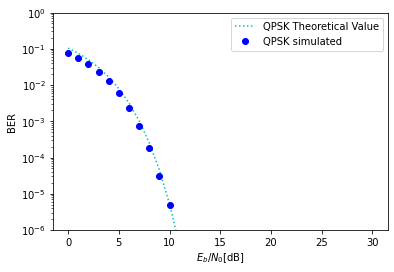

In [ ]:
#理論式
mode = "PSK"
gammaMode = "EbN0"
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "BER"

plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 2,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':c',
    label = "QPSK Theoretical Value"
)


#実験結果
plt.plot(
    np.loadtxt(path + "/BER_EbN0_QPSK.csv")[0],
    np.loadtxt(path + "/BER_EbN0_QPSK.csv")[1],
    'ob',
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.ylim(10 ** (-6), 1)

plt.legend()

plt.savefig(path + "/BER_EbN0_QPSK.png")

plt.show()

### 8PSK

#### SER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 8 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "SER"

#変調方式
mode = "PSK"

#多値数
M = 3

#試行回数
iterationNum = 1000000

#Eb/N0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

通信モデル等設定

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

In [ ]:
#乱数データ
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])

#データを変調しておく
symbol = modulator.modulate(dataOrigin)

##### 実行結果
横軸 $E_b/N_0$[dB]，縦軸 SER(対数表示)のグラフを描く.

In [ ]:
SER_EbN0_8PSK = np.zeros(shape = SNR.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = SNR[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてSER計算
  ser = errorCalculator.calcError(dataOrigin, dataDemodulated)

  SER_EbN0_8PSK[n] = ser
  print("EbN0 :{} SER:{}".format(EbN0[n], ser) )

EbN0 :0.0 SER:0.348035
EbN0 :1.0 SER:0.293194
EbN0 :2.0 SER:0.237599
EbN0 :3.0 SER:0.185289
EbN0 :4.0 SER:0.136857
EbN0 :5.0 SER:0.095681
EbN0 :6.0 SER:0.061024
EbN0 :7.0 SER:0.035619
EbN0 :8.0 SER:0.018753
EbN0 :9.0 SER:0.008267
EbN0 :10.0 SER:0.003053
EbN0 :11.0 SER:0.000897
EbN0 :12.0 SER:0.000206
EbN0 :13.0 SER:2.5e-05
EbN0 :14.0 SER:2e-06
EbN0 :15.0 SER:0.0
EbN0 :16.0 SER:0.0
EbN0 :17.0 SER:0.0
EbN0 :18.0 SER:0.0
EbN0 :19.0 SER:0.0
EbN0 :20.0 SER:0.0
EbN0 :21.0 SER:0.0
EbN0 :22.0 SER:0.0
EbN0 :23.0 SER:0.0
EbN0 :24.0 SER:0.0
EbN0 :25.0 SER:0.0
EbN0 :26.0 SER:0.0
EbN0 :27.0 SER:0.0
EbN0 :28.0 SER:0.0
EbN0 :29.0 SER:0.0
EbN0 :30.0 SER:0.0


In [ ]:
np.savetxt("SER_EbN0_8PSK.csv", np.stack([
    EbN0,
    SER_EbN0_8PSK
]))

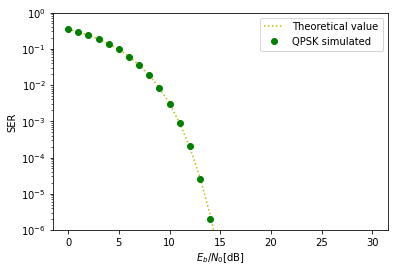

In [ ]:
EbN0 = np.loadtxt("SER_EbN0_8PSK.csv")[0]

plt.plot(
    EbN0,
    special.erfc(
        np.sqrt( M * np.power(10, EbN0/10.0) ) * 
        np.sin(np.pi/(1<<M))
    )
    ,
    ':y',
    label = "Theoretical value"
)

plt.plot(
    np.loadtxt("SER_EbN0_8PSK.csv")[0],
    np.loadtxt("SER_EbN0_8PSK.csv")[1],
    'og',
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("SER")

plt.ylim(10 ** (-6), 1)

plt.legend()

plt.savefig("SER_EbN0_8PSK.png")

plt.show()

####  BER - E_b/N_0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 8 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 3

#試行回数
informationSize = 1000000

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])
symbol = modulator.modulate(dataOrigin)

In [ ]:
BER_EbN0_8PSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  BER_EbN0_8PSK[n] = ber
  print("EbN0: {} BER: {}".format( EbN0[n], ber) )

np.savetxt(path + "/BER_EbN0_8PSK.csv", np.stack([
    EbN0,
    BER_EbN0_8PSK
]))

EbN0: 0.0 BER: 0.14718066666666665
EbN0: 1.0 BER: 0.12328566666666667
EbN0: 2.0 BER: 0.09958166666666667
EbN0: 3.0 BER: 0.07723933333333333
EbN0: 4.0 BER: 0.057114333333333336
EbN0: 5.0 BER: 0.039870666666666665
EbN0: 6.0 BER: 0.025568333333333332
EbN0: 7.0 BER: 0.014918333333333334
EbN0: 8.0 BER: 0.007782666666666667
EbN0: 9.0 BER: 0.003374
EbN0: 10.0 BER: 0.0012963333333333334
EbN0: 11.0 BER: 0.0003446666666666667
EbN0: 12.0 BER: 7.833333333333333e-05
EbN0: 13.0 BER: 1.4333333333333334e-05
EbN0: 14.0 BER: 1e-06
EbN0: 15.0 BER: 0.0
EbN0: 16.0 BER: 0.0
EbN0: 17.0 BER: 0.0
EbN0: 18.0 BER: 0.0
EbN0: 19.0 BER: 0.0
EbN0: 20.0 BER: 0.0
EbN0: 21.0 BER: 0.0
EbN0: 22.0 BER: 0.0
EbN0: 23.0 BER: 0.0
EbN0: 24.0 BER: 0.0
EbN0: 25.0 BER: 0.0
EbN0: 26.0 BER: 0.0
EbN0: 27.0 BER: 0.0
EbN0: 28.0 BER: 0.0
EbN0: 29.0 BER: 0.0
EbN0: 30.0 BER: 0.0


In [ ]:
np.savetxt("BER_EbN0_8PSK.csv", np.stack([
    EbN0,
    BER_EbN0_8PSK
]))

##### 実行結果

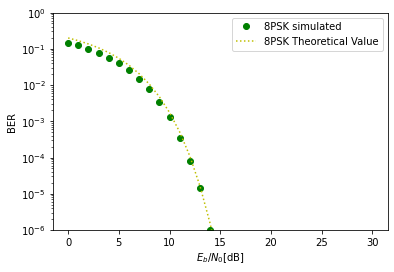

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/BER_EbN0_8PSK.csv")[0],
    np.loadtxt(path + "/BER_EbN0_8PSK.csv")[1],
    'og',
    label = "8PSK simulated"
)


#理論式
mode = "PSK"
gammaMode = "EbN0"
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "BER"


plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 3,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':y',
    label = "8PSK Theoretical Value"
)


plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.ylim(10 ** (-6), 1)

plt.legend()

plt.savefig(path + "/BER_EbN0_8PSK.png")

plt.show()

## simulation of MQAM

### 16QAM


#### BER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | QAM |
| 多値数 | 16 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "QAM"

#多値数
M = 4

#試行回数
iterationNum = 1000000

#Eb/N0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])
symbol = modulator.modulate(dataOrigin)

実行

In [ ]:
BER_EbN0_16QAM = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcBER(dataOrigin, dataDemodulated)

  BER_EbN0_16QAM[n] = ber
  print("{} ber: {}".format(EbN0[n], ber) )

#保存
np.savetxt(path + "BER_EbN0_16QAM.csv", np.stack([
    EbN0,
    BER_EbN0_16QAM
]))

0.0 ber: 0.140731
1.0 ber: 0.11884125
2.0 ber: 0.09779325
3.0 ber: 0.07745675
4.0 ber: 0.0588655
5.0 ber: 0.04184725
6.0 ber: 0.02785675
7.0 ber: 0.01691075
8.0 ber: 0.00927025
9.0 ber: 0.00446
10.0 ber: 0.00176675
11.0 ber: 0.00057325
12.0 ber: 0.0001265
13.0 ber: 2.375e-05
14.0 ber: 3e-06
15.0 ber: 0.0
16.0 ber: 0.0
17.0 ber: 0.0
18.0 ber: 0.0
19.0 ber: 0.0
20.0 ber: 0.0
21.0 ber: 0.0
22.0 ber: 0.0
23.0 ber: 0.0
24.0 ber: 0.0
25.0 ber: 0.0
26.0 ber: 0.0
27.0 ber: 0.0
28.0 ber: 0.0
29.0 ber: 0.0
30.0 ber: 0.0


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks"

In [ ]:
np.savetxt(path + "/BER_EbN0_16QAM.csv", np.stack([
    EbN0,
    BER_EbN0_16QAM
]))

##### 実行結果

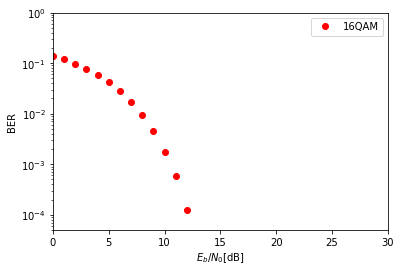

In [ ]:
#16QAMの実行結果
plt.plot(
    np.loadtxt(path + "BER_EbN0_16QAM.csv")[0],
    np.loadtxt(path + "BER_EbN0_16QAM.csv")[1],
    'or',
    label = "16QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 5.0 * 10 ** (-5), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig(path + "/BER_EbN0_16QAM.png")

plt.show()

#### SER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 16 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "SER"

#変調方式
mode = "QAM"

#多値数
M = 4

#試行回数
iterationNum = 1000000

#SNR
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])
symbol = modulator.modulate(dataOrigin)

実行

In [ ]:
SER_EbN0_16QAM = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてSER計算
  ser = errorCalculator.calcError(dataOrigin, dataDemodulated)

  SER_EbN0_16QAM[n] = ser
  print("{}/{} ser: {}".format(n, N, ser) )

np.savetxt(path + "/SER_EbN0_16QAM.csv", np.stack([
    EbN0,
    SER_EbN0_16QAM
]))

0/31 ser: 0.479909
1/31 ser: 0.417485
2/31 ser: 0.352704
3/31 ser: 0.285459
4/31 ser: 0.219899
5/31 ser: 0.160634
6/31 ser: 0.108523
7/31 ser: 0.066771
8/31 ser: 0.03679
9/31 ser: 0.017442
10/31 ser: 0.00707
11/31 ser: 0.002263
12/31 ser: 0.000629
13/31 ser: 9.5e-05
14/31 ser: 1.3e-05
15/31 ser: 0.0
16/31 ser: 0.0
17/31 ser: 0.0
18/31 ser: 0.0
19/31 ser: 0.0
20/31 ser: 0.0
21/31 ser: 0.0
22/31 ser: 0.0
23/31 ser: 0.0
24/31 ser: 0.0
25/31 ser: 0.0
26/31 ser: 0.0
27/31 ser: 0.0
28/31 ser: 0.0
29/31 ser: 0.0
30/31 ser: 0.0


##### 実行結果

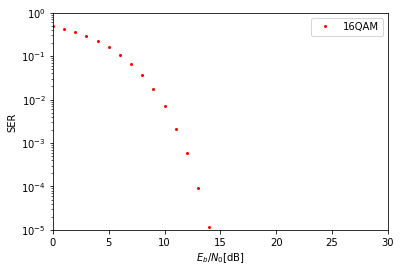

In [ ]:
#16QAMの実行結果
plt.plot(
    np.loadtxt(path + '/SER_EbN0_16QAM.csv')[0],
    np.loadtxt(path + '/SER_EbN0_16QAM.csv')[1],
    'or',
    markersize = 2,
    label = "16QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 10 ** (-5), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("SER")

plt.legend()

plt.savefig(path + "/SER_EbN0_16QAM.png")

plt.show()

### 64QAM


#### BER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | QAM |
| 多値数 | 64 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "QAM"

#多値数
M = 6

#試行回数
iterationNum = 1000000

#Eb/N0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])
symbol = modulator.modulate(dataOrigin)

実行

In [ ]:
BER_EbN0_64QAM = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  BER_EbN0_64QAM[n] = ber
  print("{} ber: {}".format(EbN0[n], ber) )

np.savetxt(path + "/BER_EbN0_64QAM.csv", np.stack([
    EbN0,
    BER_EbN0_64QAM
]))

0.0 ber: 0.21128733333333333
1.0 ber: 0.19156716666666668
2.0 ber: 0.172226
3.0 ber: 0.1531065
4.0 ber: 0.13375566666666666
5.0 ber: 0.11443616666666667
6.0 ber: 0.095591
7.0 ber: 0.07698033333333333
8.0 ber: 0.0599225
9.0 ber: 0.043803666666666664
10.0 ber: 0.030280166666666667
11.0 ber: 0.019262166666666667
12.0 ber: 0.011122666666666666
13.0 ber: 0.0056805
14.0 ber: 0.0024831666666666665
15.0 ber: 0.0008891666666666667
16.0 ber: 0.00023933333333333334
17.0 ber: 4.933333333333333e-05
18.0 ber: 6.5e-06
19.0 ber: 3.3333333333333335e-07
20.0 ber: 0.0
21.0 ber: 0.0
22.0 ber: 0.0
23.0 ber: 0.0
24.0 ber: 0.0
25.0 ber: 0.0
26.0 ber: 0.0
27.0 ber: 0.0
28.0 ber: 0.0
29.0 ber: 0.0
30.0 ber: 0.0


##### 実行結果

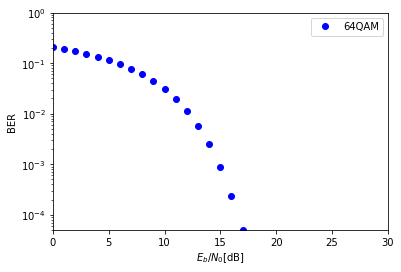

In [ ]:
#64QAMの実行結果
plt.plot(
    np.loadtxt(path + "/BER_EbN0_64QAM.csv")[0],
    np.loadtxt(path + "/BER_EbN0_64QAM.csv")[1],
    'ob',
    label = "64QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 5.0 * 10 ** (-5), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig(path + "/BER_EbN0_64QAM.png")

plt.show()

#### SER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 16 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "SER"

#変調方式
mode = "QAM"

#多値数
M = 6

#試行回数
iterationNum = 1000000

#SNR
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])
symbol = modulator.modulate(dataOrigin)

実行

In [ ]:
SER_EbN0_64QAM = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = SNR[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてSER計算
  ser = errorCalculator.calcError(dataOrigin, dataDemodulated)

  SER_EbN0_64QAM[n] = ser
  print("{}/{} ser: {}".format(n, N, ser) )

np.savetxt(path + "/SER_EbN0_64QAM.csv", np.stack([
    EbN0,
    SER_EbN0_64QAM
]))

0/31 ser: 0.768476
1/31 ser: 0.728882
2/31 ser: 0.684292
3/31 ser: 0.632405
4/31 ser: 0.573491
5/31 ser: 0.507736
6/31 ser: 0.438595
7/31 ser: 0.364753
8/31 ser: 0.28989
9/31 ser: 0.218601
10/31 ser: 0.15323
11/31 ser: 0.099038
12/31 ser: 0.057738
13/31 ser: 0.029646
14/31 ser: 0.012836
15/31 ser: 0.0045
16/31 ser: 0.001318
17/31 ser: 0.000238
18/31 ser: 4.7e-05
19/31 ser: 3e-06
20/31 ser: 0.0
21/31 ser: 0.0
22/31 ser: 0.0
23/31 ser: 0.0
24/31 ser: 0.0
25/31 ser: 0.0
26/31 ser: 0.0
27/31 ser: 0.0
28/31 ser: 0.0
29/31 ser: 0.0
30/31 ser: 0.0


##### 実行結果

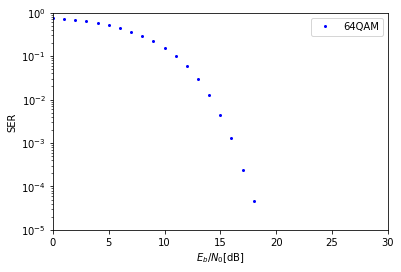

In [ ]:
#64QAMの実行結果
plt.plot(
    np.loadtxt(path + '/SER_EbN0_64QAM.csv')[0],
    np.loadtxt(path + '/SER_EbN0_64QAM.csv')[1],
    'ob',
    markersize = 2,
    label = "64QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 10 ** (-5), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("SER")

plt.legend()

plt.savefig(path + "/SER_EbN0_64QAM.png")

plt.show()

### 256QAM


#### BER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | QAM |
| 多値数 | 256 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "QAM"

#多値数
M = 8

#試行回数
iterationNum = 1000000

#Eb/N0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])
symbol = modulator.modulate(dataOrigin)

実行

In [ ]:
BER_EbN0_256QAM = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  BER_EbN0_256QAM[n] = ber
  print("{} ber: {}".format(EbN0[n], ber) )

np.savetxt(path + "/BER_EbN0_256QAM.csv", np.stack([
    EbN0,
    BER_EbN0_256QAM
]))

0.0 ber: 0.263009125
1.0 ber: 0.247053375
2.0 ber: 0.230735375
3.0 ber: 0.21354475
4.0 ber: 0.196331
5.0 ber: 0.178886875
6.0 ber: 0.161292625
7.0 ber: 0.143889375
8.0 ber: 0.12698925
9.0 ber: 0.110336375
10.0 ber: 0.093850125
11.0 ber: 0.07785925
12.0 ber: 0.062335375
13.0 ber: 0.048029125
14.0 ber: 0.035037375
15.0 ber: 0.0238065
16.0 ber: 0.014968625
17.0 ber: 0.008398625
18.0 ber: 0.004193625
19.0 ber: 0.00174725
20.0 ber: 0.000622125
21.0 ber: 0.00016225
22.0 ber: 3.5375e-05
23.0 ber: 3.5e-06
24.0 ber: 2.5e-07
25.0 ber: 0.0
26.0 ber: 0.0
27.0 ber: 0.0
28.0 ber: 0.0
29.0 ber: 0.0
30.0 ber: 0.0


##### 実行結果

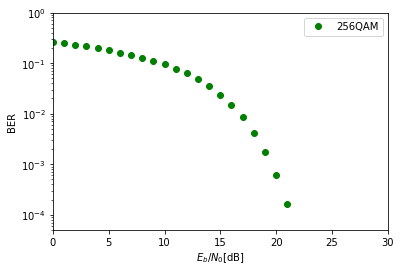

In [ ]:
#256QAMの実行結果
plt.plot(
    np.loadtxt(path + "/BER_EbN0_256QAM.csv")[0],
    np.loadtxt(path + "/BER_EbN0_256QAM.csv")[1],
    'og',
    label = "256QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 5.0 * 10 ** (-5), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.legend()

plt.savefig(path + "/BER_EbN0_256QAM.png")

plt.show()

#### SER-Eb/N0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 256 |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "SER"

#変調方式
mode = "QAM"

#多値数
M = 8

#試行回数
iterationNum = 1000000

#SNR
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, iterationNum])
symbol = modulator.modulate(dataOrigin)

実行

In [ ]:
SER_EbN0_256QAM = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = SNR[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてSER計算
  ser = errorCalculator.calcError(dataOrigin, dataDemodulated)

  SER_EbN0_256QAM[n] = ser
  print("{}/{} ser: {}".format(n, N, ser) )

np.savetxt(path + "/SER_EbN0_256QAM.csv", np.stack([
    EbN0,
    SER_EbN0_256QAM
]))

0/31 ser: 0.916353
1/31 ser: 0.900362
2/31 ser: 0.881582
3/31 ser: 0.858229
4/31 ser: 0.829575
5/31 ser: 0.796156
6/31 ser: 0.757119
7/31 ser: 0.709855
8/31 ser: 0.655801
9/31 ser: 0.594953
10/31 ser: 0.525111
11/31 ser: 0.450329
12/31 ser: 0.372073
13/31 ser: 0.294649
14/31 ser: 0.219572
15/31 ser: 0.152775
16/31 ser: 0.097099
17/31 ser: 0.055383
18/31 ser: 0.027613
19/31 ser: 0.011735
20/31 ser: 0.003992
21/31 ser: 0.001095
22/31 ser: 0.000205
23/31 ser: 3.5e-05
24/31 ser: 3e-06
25/31 ser: 0.0
26/31 ser: 0.0
27/31 ser: 0.0
28/31 ser: 0.0
29/31 ser: 0.0
30/31 ser: 0.0


##### 実行結果

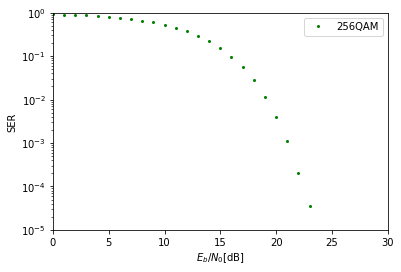

In [ ]:
#256QAMの実行結果
plt.plot(
    np.loadtxt(path + '/SER_EbN0_256QAM.csv')[0],
    np.loadtxt(path + '/SER_EbN0_256QAM.csv')[1],
    'og',
    markersize = 2,
    label = "256QAM"
)

plt.yscale('log')

plt.xlim( 0, 30 )
plt.ylim( 10 ** (-5), 1 )

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("SER")

plt.legend()

plt.savefig(path + "/SER_EbN0_256QAM.png")

plt.show()

## まとめ


### PSK

#### BER-Eb/N0

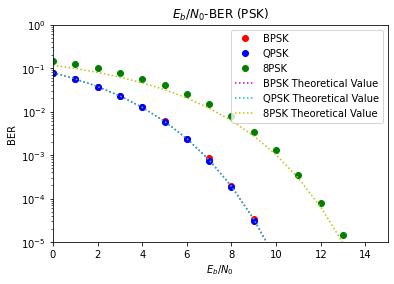

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/BER_SNR_BPSK.csv")[0],
    np.loadtxt(path + "/BER_SNR_BPSK.csv")[1],
    'or', 
    label = "BPSK"
)

plt.plot(
    np.loadtxt(path + "/BER_EbN0_QPSK.csv")[0],
    np.loadtxt(path + "/BER_EbN0_QPSK.csv")[1],
    'ob',
    label = "QPSK"
)

plt.plot(
    np.loadtxt(path + "/BER_EbN0_8PSK.csv")[0],
    np.loadtxt(path + "/BER_EbN0_8PSK.csv")[1],
    'og',
    label = "8PSK"
)

#理論式
mode = "PSK"
gammaMode = "EbN0"
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "BER"

plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 1,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':m',
    label = "BPSK Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 2,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':c',
    label = "QPSK Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 3,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':y',
    label = "8PSK Theoretical Value"
)


plt.xlabel("$E_b/N_0$")
plt.ylabel("BER")

plt.yscale("log")

plt.xlim(0, 15)
plt.ylim(10 ** (-5), 1)

plt.title("$E_b/N_0$-BER (PSK)")

plt.legend()


plt.savefig(path + "/BER_EbN0_PSK.png")


#### SER-Eb/N0

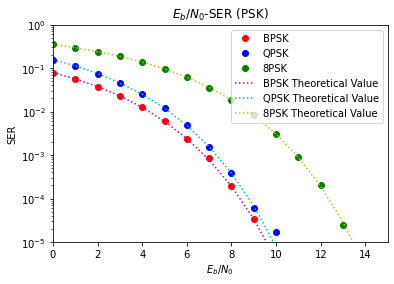

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/BER_SNR_BPSK.csv")[0],
    np.loadtxt(path + "/BER_SNR_BPSK.csv")[1],
    'or', 
    label = "BPSK"
)
plt.plot(
    np.loadtxt(path + "/SER_EbN0_QPSK.csv")[0],
    np.loadtxt(path + "/SER_EbN0_QPSK.csv")[1],
    'ob',
    label = "QPSK"
)
plt.plot(
    np.loadtxt(path + "/SER_EbN0_8PSK.csv")[0],
    np.loadtxt(path + "/SER_EbN0_8PSK.csv")[1],
    'og',
    label = "8PSK"
)

#理論式
mode = "PSK"
gammaMode = "EbN0"
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "SER"

plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 1,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':m',
    label = "BPSK Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 2,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':c',
    label = "QPSK Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 3,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':y',
    label = "8PSK Theoretical Value"
)

plt.xlabel("$E_b/N_0$")
plt.ylabel("SER")

plt.yscale("log")

plt.xlim(0, 15)
plt.ylim(10 ** (-5), 1)

plt.title("$E_b/N_0$-SER (PSK)")

plt.legend()


plt.savefig(path + "/SER_EbN0_PSK.png")

### QAM

#### BER-EbN0

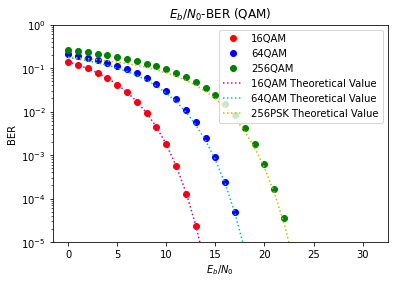

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/BER_EbN0_16QAM.csv")[0],
    np.loadtxt(path + "/BER_EbN0_16QAM.csv")[1],
    'or', 
    label = "16QAM"
)
plt.plot(
    np.loadtxt(path + '/BER_EbN0_64QAM.csv')[0],
    np.loadtxt(path + '/BER_EbN0_64QAM.csv')[1],
    'ob',
    label = "64QAM"
)
plt.plot(
    np.loadtxt(path + "/BER_EbN0_256QAM.csv")[0],
    np.loadtxt(path + "/BER_EbN0_256QAM.csv")[1],
    'og',
    label = "256QAM"
)


#理論式
mode = "QAM"
gammaMode = "EbN0"
EbN0_MIN, EbN0_MAX = 0, 31
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "BER"

plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 4,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':m',
    label = "16QAM Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 6,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':c',
    label = "64QAM Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 8,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':y',
    label = "256PSK Theoretical Value"
)


plt.xlabel("$E_b/N_0$")
plt.ylabel("BER")

plt.yscale("log")

plt.ylim(10 ** (-5), 1)

plt.title("$E_b/N_0$-BER (QAM)")

plt.legend()

plt.savefig(path + "/BER_EbN0_QAM.png")

#### SER-Eb/N0

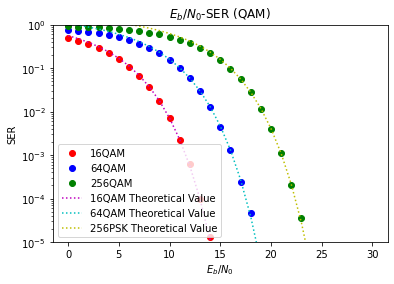

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/SER_EbN0_16QAM.csv")[0],
    np.loadtxt(path + "/SER_EbN0_16QAM.csv")[1],
    'or', 
    label = "16QAM"
)
plt.plot(
    np.loadtxt(path + '/SER_EbN0_64QAM.csv')[0],
    np.loadtxt(path + '/SER_EbN0_64QAM.csv')[1],
    'ob',
    label = "64QAM"
)
plt.plot(
    np.loadtxt(path + "/SER_EbN0_256QAM.csv")[0],
    np.loadtxt(path + "/SER_EbN0_256QAM.csv")[1],
    'og',
    label = "256QAM"
)


#理論式
mode = "QAM"
gammaMode = "EbN0"
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "SER"

plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 4,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':m',
    label = "16QAM Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 6,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':c',
    label = "64QAM Theoretical Value"
)
plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 8,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':y',
    label = "256PSK Theoretical Value"
)

plt.xlabel("$E_b/N_0$")
plt.ylabel("SER")

plt.yscale("log")

#plt.xlim(0, 15)
plt.ylim(10 ** (-5), 1)

plt.title("$E_b/N_0$-SER (QAM)")

plt.legend()

plt.savefig(path + "/SER_EbN0_QAM.png")